In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from xgboost import XGBRegressor,plot_importance
from sklearn import preprocessing,pipeline,linear_model,neural_network,model_selection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from statsmodels.tsa.api import VAR

from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
df  = pd.read_csv("M2SLMoneyStock.csv",parse_dates=True,index_col=0)
df.index.freq  = 'MS'

sp = pd.read_csv("PCEPersonalSpending.csv",parse_dates=True,index_col=0)
sp.index.freq  = 'MS'

In [4]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [5]:
df.isnull().sum()

Money       0
Spending    0
dtype: int64

In [6]:
df.shape

(252, 2)

In [7]:
df = df.dropna()

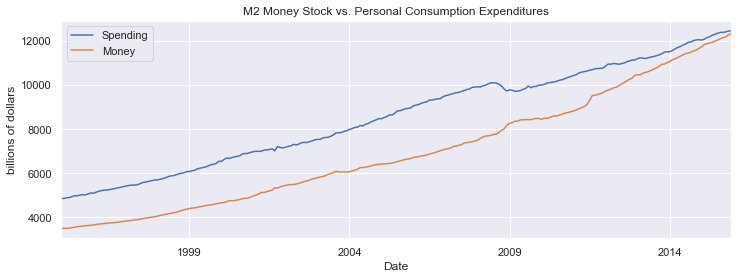

In [8]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel = "billions of dollars"

ax = df['Spending'].plot(legend = True,figsize = (12,4),title = title)
df['Money'].plot(legend = True)
ax.set(ylabel = ylabel)
ax.autoscale(axis = 'x',tight = True)

In [9]:
#labels = ['ADF test statistic','p-value','# lags used','# observations']
#print("Strong evidence against the null hypothesis")
       # print("Reject the null hypothesis")
        #print("Data has no unit root and is stationary")
        
def adf_test(series,title = ''):
    print(f'The augmented dickey fuller test : {title}')
    
    result  = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'The critical value ({key})'] = val
    
    print(out.to_string())
    
    if result[1]<0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Strong evidence for the null hypothesis")
        print("accept the null hypothesis")
        print("Data has unit root and is non- stationary")
        
    

In [10]:
adf_test(df['Money'])

The augmented dickey fuller test : 
ADF test statistic            4.239022
p-value                       1.000000
# lags used                   4.000000
# observations              247.000000
The critical value (1%)      -3.457105
The critical value (5%)      -2.873314
The critical value (10%)     -2.573044
Strong evidence for the null hypothesis
accept the null hypothesis
Data has unit root and is non- stationary


In [11]:
adf_test(df['Spending'])

The augmented dickey fuller test : 
ADF test statistic            0.149796
p-value                       0.969301
# lags used                   3.000000
# observations              248.000000
The critical value (1%)      -3.456996
The critical value (5%)      -2.873266
The critical value (10%)     -2.573019
Strong evidence for the null hypothesis
accept the null hypothesis
Data has unit root and is non- stationary


In [12]:
df_transformed = df.diff()

In [13]:
adf_test(df_transformed['Money'])

The augmented dickey fuller test : 
ADF test statistic           -2.057404
p-value                       0.261984
# lags used                  15.000000
# observations              235.000000
The critical value (1%)      -3.458487
The critical value (5%)      -2.873919
The critical value (10%)     -2.573367
Strong evidence for the null hypothesis
accept the null hypothesis
Data has unit root and is non- stationary


In [14]:
adf_test(df_transformed['Spending'])

The augmented dickey fuller test : 
ADF test statistic         -7.226974e+00
p-value                     2.041027e-10
# lags used                 2.000000e+00
# observations              2.480000e+02
The critical value (1%)    -3.456996e+00
The critical value (5%)    -2.873266e+00
The critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [15]:
df_transformed = df_transformed.diff()

In [16]:
adf_test(df_transformed['Money'])

The augmented dickey fuller test : 
ADF test statistic         -7.077471e+00
p-value                     4.760675e-10
# lags used                 1.400000e+01
# observations              2.350000e+02
The critical value (1%)    -3.458487e+00
The critical value (5%)    -2.873919e+00
The critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [17]:
adf_test(df_transformed['Spending'])

The augmented dickey fuller test : 
ADF test statistic         -8.760145e+00
p-value                     2.687900e-14
# lags used                 8.000000e+00
# observations              2.410000e+02
The critical value (1%)    -3.457779e+00
The critical value (5%)    -2.873609e+00
The critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
df_transformed.dropna(inplace = True)

In [19]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [20]:
decompose = seasonal_decompose(df_transformed['Money'],model = 'additive')

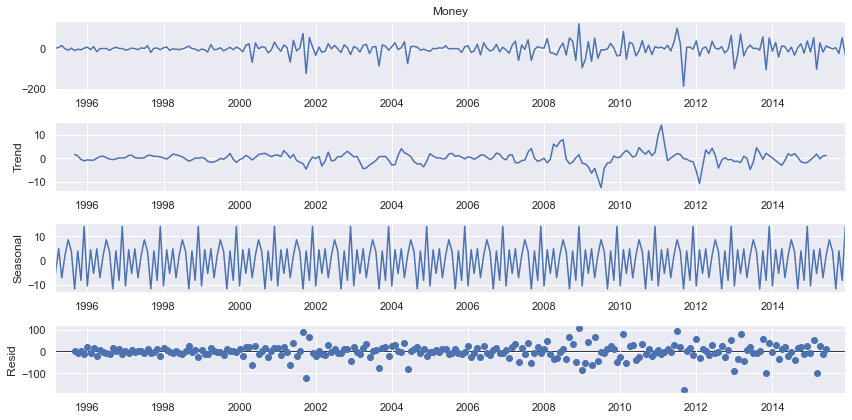

In [21]:
plt.rcParams["figure.figsize"] = [12,6]
decompose.plot();

In [22]:
len(df_transformed)

250

In [23]:
nobs = 12
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

In [24]:
train.shape

(238, 2)

In [25]:
test.shape

(12, 2)

In [26]:
for i in [1,2,3,4,5,6,7]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  14.178610495220896
BIC:  14.266409486135709

Order = 2
AIC:  13.955189367163705
BIC:  14.101961901274958

Order = 3
AIC:  13.849518291541038
BIC:  14.055621258341116

Order = 4
AIC:  13.827950574458281
BIC:  14.093744506408875

Order = 5
AIC:  13.78730034460964
BIC:  14.113149468980652

Order = 6
AIC:  13.799076756885809
BIC:  14.185349048538068

Order = 7
AIC:  13.797638727913972
BIC:  14.244705963046671



In [27]:
model.endog_names

['Money', 'Spending']

In [28]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, Nov, 2020
Time:                     13:52:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [29]:
lag_order = results.k_ar
lag_order

5

In [30]:
z = results.forecast(y = train.values[-lag_order:],steps = 12) #forecast instead of predict

In [31]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [32]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [33]:
idx = pd.date_range('2015-01-01',periods = 12,freq='MS')
df_forecast = pd.DataFrame(z,index=idx,columns = ['Money2d','Spending2d'])
df_forecast

,Money2d,Spending2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [34]:
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]- df['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [35]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]- df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2d'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [36]:
df_forecast

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


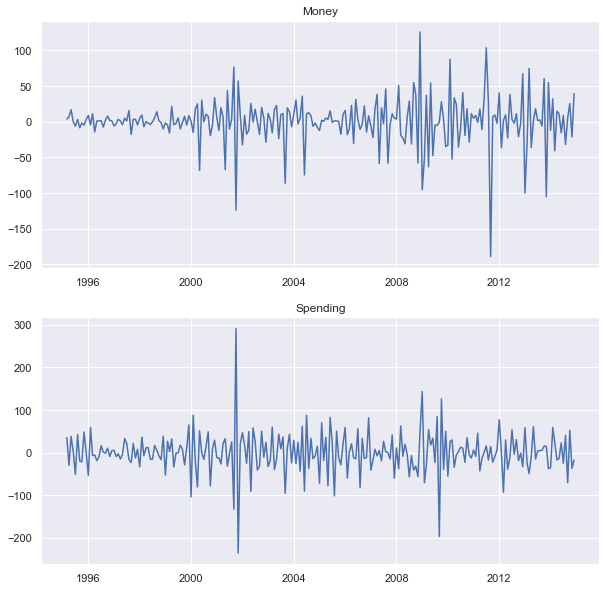

In [37]:
results.plot();

In [38]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, Nov, 2020
Time:                     13:52:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

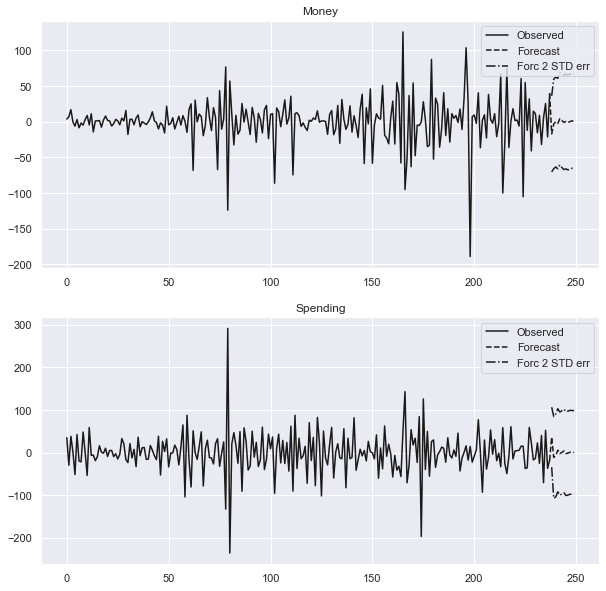

In [39]:

results.plot_forecast(12,);

In [40]:
error1 = rmse(df['Money'][-nobs:],df_forecast['MoneyForecast'])
print(f'The RMSE score for Money forecast is :{error1: 0.3f}')

The RMSE score for Money forecast is : 43.710


In [41]:
error2 = rmse(df['Spending'][-nobs:],df_forecast['SpendingForecast'])
print(f'The RMSE score for spending forecast is :{error2: 0.3f}')

The RMSE score for spending forecast is : 37.001


### let's  compare the result with AR model

In [42]:
from statsmodels.tsa.ar_model import AR,ARResults

In [43]:
model_AR = AR(train['Money'])
result = model_AR.fit(maxlag = 5,method = 'mle')

In [44]:
print(f' Lag :{result.k_ar}')
print(f'Coefficients :\n{result.params}')

 Lag :5
Coefficients :
const       0.585226
L1.Money   -0.605217
L2.Money   -0.465398
L3.Money   -0.228645
L4.Money   -0.311354
L5.Money   -0.127613
dtype: float64


In [45]:
start = len(train)
end = len(train) + len(test) - 1
z1 = pd.DataFrame(result.predict(start = start,end = end,dynamic = False),columns = ['Money'])
z1

,Money
2015-01-01,-16.911034
2015-02-01,-11.347176
2015-03-01,9.669321
2015-04-01,-5.699570
2015-05-01,2.353692
2015-06-01,5.293524
2015-07-01,-3.973264
2015-08-01,0.528810
2015-09-01,0.898501
2015-10-01,-1.244727


In [46]:
z1['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()
z1['Moneyforecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [47]:
z1

,Money,Money1d,Moneyforecast
2015-01-01,-16.911034,61.688966,11731.788966
2015-02-01,-11.347176,50.341790,11782.130755
2015-03-01,9.669321,60.011111,11842.141867
2015-04-01,-5.699570,54.311541,11896.453407
2015-05-01,2.353692,56.665233,11953.118640
2015-06-01,5.293524,61.958757,12015.077397
2015-07-01,-3.973264,57.985493,12073.062890
2015-08-01,0.528810,58.514303,12131.577193
2015-09-01,0.898501,59.412804,12190.989997
2015-10-01,-1.244727,58.168077,12249.158075


In [48]:
rmse_AR = rmse(df['Money'][-nobs:],z1['Moneyforecast'])
print(f'the money forecast for AR is: {rmse_AR: 0.3f}')
print(f'The RMSE score for Money forecast (var) is :{error1: 0.3f}')

the money forecast for AR is:  36.222
The RMSE score for Money forecast (var) is : 43.710


In [120]:
model_ARx = AR(train['Spending'])
resultx = model_ARx.fit(maxlag = 5,method = 'mle')

In [121]:
print(f' Lag :{resultx.k_ar}')
print(f'Coefficients :\n{resultx.params}')

 Lag :5
Coefficients :
const          0.221183
L1.Spending   -0.913123
L2.Spending   -0.677036
L3.Spending   -0.450798
L4.Spending   -0.273219
L5.Spending   -0.159475
dtype: float64


In [122]:
start = len(train)
end = len(train) + len(test) - 1
z2 = pd.DataFrame(resultx.predict(start = start,end = end,dynamic = False),columns = ['Spending'])
z2

,Spending
2015-01-01,30.883379
2015-02-01,-2.227336
2015-03-01,-8.838640
2015-04-01,6.673542
2015-05-01,-4.483697
2015-06-01,-0.535015
2015-07-01,3.507013
2015-08-01,-1.011483
2015-09-01,-0.827632
2015-10-01,0.941983


In [123]:
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()
z2['Spendingforecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [124]:
z2

,Spending,Spending1d,Spendingforecast
2015-01-01,30.883379,41.483379,12103.483379
2015-02-01,-2.227336,39.256043,12142.739422
2015-03-01,-8.838640,30.417403,12173.156826
2015-04-01,6.673542,37.090946,12210.247771
2015-05-01,-4.483697,32.607249,12242.855020
2015-06-01,-0.535015,32.072234,12274.927254
2015-07-01,3.507013,35.579247,12310.506501
2015-08-01,-1.011483,34.567764,12345.074266
2015-09-01,-0.827632,33.740132,12378.814398
2015-10-01,0.941983,34.682115,12413.496513


In [125]:
rmse_ARx = rmse(df['Spending'][-nobs:],z2['Spendingforecast'])
print(f'the spending forecast for AR is: {rmse_ARx: 0.3f}')
print(f'The RMSE score for spending forecast (var) is :{error2: 0.3f}')

the spending forecast for AR is:  34.121
The RMSE score for spending forecast (var) is : 37.001


#### CONCLUSION: It looks like the VAR(5) model did not do better than the individual AR(5) models. That's ok - we know more than we did before. In the next section we'll look at VARMA and see if the addition of a  𝑞  parameter helps.

## VARMA

In [54]:
nobs = 12
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

In [55]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [56]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, with_intercept=False)

In [57]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={})

## VARMA(1,2) model

In [60]:
model_ma = VARMAX(train,order=(1,2),trend='c')
result_ma = model_ma.fit(maxiter =1000,disp = False)
result_ma.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2285.995
,+ intercept,AIC,4605.991
Date:,"Thu, 05 Nov 2020",BIC,4665.019
Time:,14:10:28,HQIC,4629.780
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.35, 28.45",Jarque-Bera (JB):,"562.85, 120.80"
Prob(Q):,"0.00, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.60, 2.95",Skew:,"1.34, -0.34"


In [92]:
df_fcast_ma = result_ma.forecast(12)
df_fcast_ma


,Money,Spending
2015-01-01,-11.507797,38.528861
2015-02-01,-10.854276,-5.799079
2015-03-01,0.982131,-0.113742
2015-04-01,-1.352200,-0.560029
2015-05-01,0.722379,0.238935
2015-06-01,-0.159126,-0.047330
2015-07-01,0.342715,0.130365
2015-08-01,0.092232,0.044713
2015-09-01,0.224527,0.090667
2015-10-01,0.156367,0.067151


In [96]:
dfc = result_ma.predict(start = len(train),end = len(train) + len(test) - 1,dynamic = False)
dfc

,Money,Spending
2015-01-01,-11.507797,38.528861
2015-02-01,-10.854276,-5.799079
2015-03-01,0.982131,-0.113742
2015-04-01,-1.352200,-0.560029
2015-05-01,0.722379,0.238935
2015-06-01,-0.159126,-0.047330
2015-07-01,0.342715,0.130365
2015-08-01,0.092232,0.044713
2015-09-01,0.224527,0.090667
2015-10-01,0.156367,0.067151


In [63]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_fcast_ma['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_fcast_ma['Money'].cumsum()

# Now build the forecast values from the first difference set
df_fcast_ma['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_fcast_ma['Money'].cumsum()

In [64]:
df_fcast_ma

,Money,Spending,Money1d,MoneyForecast
2015-01-01,-11.507797,38.528861,67.092203,11658.592203
2015-02-01,-10.854276,-5.799079,56.237927,11647.737927
2015-03-01,0.982131,-0.113742,57.220058,11648.720058
2015-04-01,-1.352200,-0.560029,55.867858,11647.367858
2015-05-01,0.722379,0.238935,56.590237,11648.090237
2015-06-01,-0.159126,-0.047330,56.431111,11647.931111
2015-07-01,0.342715,0.130365,56.773826,11648.273826
2015-08-01,0.092232,0.044713,56.866058,11648.366058
2015-09-01,0.224527,0.090667,57.090585,11648.590585
2015-10-01,0.156367,0.067151,57.246952,11648.746952


In [66]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_fcast_ma['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_fcast_ma['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_fcast_ma['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_fcast_ma['Spending'].cumsum()

In [67]:
df_fcast_ma

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.507797,38.528861,67.092203,11658.592203,49.128861,12100.528861
2015-02-01,-10.854276,-5.799079,56.237927,11647.737927,43.329782,12094.729782
2015-03-01,0.982131,-0.113742,57.220058,11648.720058,43.216040,12094.616040
2015-04-01,-1.352200,-0.560029,55.867858,11647.367858,42.656011,12094.056011
2015-05-01,0.722379,0.238935,56.590237,11648.090237,42.894946,12094.294946
2015-06-01,-0.159126,-0.047330,56.431111,11647.931111,42.847616,12094.247616
2015-07-01,0.342715,0.130365,56.773826,11648.273826,42.977981,12094.377981
2015-08-01,0.092232,0.044713,56.866058,11648.366058,43.022694,12094.422694
2015-09-01,0.224527,0.090667,57.090585,11648.590585,43.113361,12094.513361
2015-10-01,0.156367,0.067151,57.246952,11648.746952,43.180512,12094.580512


In [70]:
pd.concat([df.iloc[-12:],df_fcast_ma[['MoneyForecast','SpendingForecast']]],axis = 1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.592203,12100.528861
2015-02-01,11852.4,12082.4,11647.737927,12094.729782
2015-03-01,11868.8,12158.3,11648.720058,12094.616040
2015-04-01,11916.1,12193.8,11647.367858,12094.056011
2015-05-01,11947.6,12268.1,11648.090237,12094.294946
2015-06-01,11993.1,12308.3,11647.931111,12094.247616
2015-07-01,12045.3,12355.4,11648.273826,12094.377981
2015-08-01,12096.8,12394.0,11648.366058,12094.422694
2015-09-01,12153.8,12392.8,11648.590585,12094.513361


In [71]:
rmse_ma = rmse(df['Money'].iloc[-nobs:],df_fcast_ma['MoneyForecast'])
print(f'The RMSE of Varma (money) is : {rmse_ma : 0.3f}')

The RMSE of Varma (money) is :  423.086


In [72]:
rmse_mas = rmse(df['Spending'].iloc[-nobs:],df_fcast_ma['SpendingForecast'])
print(f'The RMSE of Varma (spending) is : {rmse_mas : 0.3f}')

The RMSE of Varma (spending) is :  243.220


In [73]:
model_arma = ARMA(train['Money'],order = (1,2))
result_arma = model_arma.fit()
result_arma.summary()
                        

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Thu, 05 Nov 2020   AIC                           2245.421
Time:                        14:43:33   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [75]:
start = len(train)
end = len(train) + len(test) -1 
z1 = result_arma.predict(start = start,end = end,dynamic = False).rename('Money')
z1 = pd.DataFrame(z1)
z1

,Money
2015-01-01,-14.498968
2015-02-01,-10.946921
2015-03-01,4.152565
2015-04-01,-1.235725
2015-05-01,0.687100
2015-06-01,0.000935
2015-07-01,0.245795
2015-08-01,0.158416
2015-09-01,0.189597
2015-10-01,0.178470


In [139]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [140]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498968,64.101032,11734.201032
2015-02-01,-10.946921,53.154111,11787.355144
2015-03-01,4.152565,57.306677,11844.661821
2015-04-01,-1.235725,56.070952,11900.732773
2015-05-01,0.687100,56.758052,11957.490825
2015-06-01,0.000935,56.758987,12014.249813
2015-07-01,0.245795,57.004782,12071.254595
2015-08-01,0.158416,57.163199,12128.417794
2015-09-01,0.189597,57.352796,12185.770590
2015-10-01,0.178470,57.531266,12243.301856


In [141]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Thu, 05 Nov 2020   AIC                           2374.823
Time:                        17:12:40   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1437           +0.0000j            4.1437            0.5000
-----------------------------------------------------------------------------
"""

In [142]:
start=len(train)
end=len(train)+len(test)-1
z3 = results.predict(start=start, end=end).rename('Spending')
z3 = pd.DataFrame(z3)
z3

,Spending
2015-01-01,33.555803
2015-02-01,-3.338243
2015-03-01,1.250714
2015-04-01,-0.310842
2015-05-01,0.220533
2015-06-01,0.039714
2015-07-01,0.101244
2015-08-01,0.080306
2015-09-01,0.087431
2015-10-01,0.085007


In [143]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z3['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z3['Spending'].cumsum()

# Now build the forecast values from the first difference set
z3['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z3['Spending1d'].cumsum()

In [144]:
z3

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555803,44.155803,12106.155803
2015-02-01,-3.338243,40.817560,12146.973362
2015-03-01,1.250714,42.068274,12189.041636
2015-04-01,-0.310842,41.757432,12230.799068
2015-05-01,0.220533,41.977965,12272.777033
2015-06-01,0.039714,42.017679,12314.794712
2015-07-01,0.101244,42.118923,12356.913634
2015-08-01,0.080306,42.199229,12399.112863
2015-09-01,0.087431,42.286660,12441.399523
2015-10-01,0.085007,42.371666,12483.771189


In [145]:
x = pd.concat([z3,z1[['MoneyForecast']]],axis = 1)
x.drop(columns=['Spending','Spending1d'],inplace = True)
x

,SpendingForecast,MoneyForecast
2015-01-01,12106.155803,11734.201032
2015-02-01,12146.973362,11787.355144
2015-03-01,12189.041636,11844.661821
2015-04-01,12230.799068,11900.732773
2015-05-01,12272.777033,11957.490825
2015-06-01,12314.794712,12014.249813
2015-07-01,12356.913634,12071.254595
2015-08-01,12399.112863,12128.417794
2015-09-01,12441.399523,12185.770590
2015-10-01,12483.771189,12243.301856


In [146]:
rmse_arma = rmse(df['Money'][-nobs:],x['MoneyForecast'])
rmse_arma2 = rmse(df['Spending'][-nobs:],x['SpendingForecast'])

print(f'THE ARMA MONEY RMSE IS : {rmse_arma: 0.3f}')
print(f'THE ARMA SPENDING RMSE IS : {rmse_arma2: 0.3f}')

THE ARMA MONEY RMSE IS :  32.236
THE ARMA SPENDING RMSE IS :  52.334


In [132]:
print(f'The RMSE of Varma (money) is : {rmse_ma : 0.3f}')
print(f'The RMSE of Varma (spending) is : {rmse_mas : 0.3f}')


The RMSE of Varma (money) is :  423.086
The RMSE of Varma (spending) is :  243.220


In [133]:
print(f'The RMSE score for Money forecast(VAR) is :{error1: 0.3f}')
print(f'The RMSE score for spending forecast(VAR) is :{error2: 0.3f}')

The RMSE score for Money forecast(VAR) is : 43.710
The RMSE score for spending forecast(VAR) is : 37.001


In [134]:
print(f'the money forecast for AR is: {rmse_AR: 0.3f}')
print(f'the spending forecast for AR is: {rmse_ARx: 0.3f}')

the money forecast for AR is:  36.222
the spending forecast for AR is:  34.121


<strong>CONCLUSION:</strong> In our analysis, the VARMA model did a relatively poor job.
It seems there is litte interdependence between Money Stock and Personal expenditure.